## 准备数据并定义函数

In [168]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

def target_fun(x):
    # 目标函数为-2/(2+sin(x))
    return -2/(2+np.sin(x)) + 0.01*np.random.rand(x.size).reshape(-1, 1)

def generate_dataset():
    # 生成数据集
    x = np.linspace(-3, 3, 600)  # 所有数据
    x_test = np.random.choice(x,int(600*0.3),replace=False)  # 测试数据
    x_test= np.sort(x_test)
    x_train = np.setdiff1d(x,x_test).reshape(-1,1)  # 训练数据
    x_test = x_test.reshape(-1,1)
    y_train = target_fun(x_train)
    y_test = target_fun(x_test)
    return (x_train,y_train),(x_test,y_test)
    

## 用numpy实现自动梯度计算

In [169]:
import numpy as np

class Matmul:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x, W):
        h = np.matmul(x, W)
        self.mem={'x': x, 'W':W}
        return h
    
    def backward(self, grad_y):
        '''
        x: shape(N, d)
        w: shape(d, d')
        grad_y: shape(N, d')
        '''
        # y = w*x
        # grad_y = dL/dy
        # grad_x = dL/dx = dL/dy * dy/dx = grad_y*w.T
        # grad_W = dL/dw = dL/dy * dy/dw = x.T*grad_y
        x = self.mem['x']
        W = self.mem['W']
        
        ####################
        '''计算矩阵乘法的对应的梯度'''
        ####################
        grad_x = np.matmul(grad_y, W.T)
        grad_W = np.matmul(x.T,grad_y)
        
        return grad_x, grad_W


class Relu:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x):
        self.mem['x']=x
        return np.where(x > 0, x, np.zeros_like(x))
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        ####################
        '''计算relu 激活函数对应的梯度'''
        ####################
        # y = max(0,x)
        # grad_x = dL/dy * dy/dx = grad_y*0/1
        x = self.mem['x']
        grad_x = (x>0).astype(np.float32) * grad_y # x是Array用三元表达式不方便
        return grad_x
    

## 建立模型

In [170]:
class myModel:
    def __init__(self):
        
        self.W1 = np.random.normal(size=[1+1, 640])*0.1
        self.W2 = np.random.normal(size=[640, 1])*0.1
        
        self.mul_h1 = Matmul()
        self.mul_h2 = Matmul()
        self.relu = Relu()
        
    def forward(self, x):
        x = x.reshape(-1, 1)
        bias = np.ones(shape=[x.shape[0], 1])
        x = np.concatenate([x, bias], axis=1)  # 增加偏置项
        self.h1 = self.mul_h1.forward(x, self.W1)
        self.h1_relu = self.relu.forward(self.h1)
        self.h2 = self.mul_h2.forward(self.h1_relu, self.W2)
            
    def backward(self, preds, y):
        self.h2_grad, self.W2_grad = self.mul_h2.backward(2*(preds-y)/y.shape[0])
        self.h1_relu_grad = self.relu.backward(self.h2_grad)
        self.h1_grad, self.W1_grad = self.mul_h1.backward(self.h1_relu_grad)
        
model = myModel()


## 训练和测试函数

In [171]:
# MSE
def compute_loss(preds, y):
    return np.mean(np.square(y-preds))
    
def train_one_step(model, x, y):
    model.forward(x)
    model.backward(model.h2,y)
    model.W1 -= 1e-1* model.W1_grad
    model.W2 -= 1e-1* model.W2_grad
    loss = compute_loss(model.h2, y)
    return model.h2, loss

def test(model, x, y):
    model.forward(x)
    loss = compute_loss(model.h2, y)
    return model.h2,loss

## 函数拟合的训练过程

epoch 0 : loss 1.7167464125645362


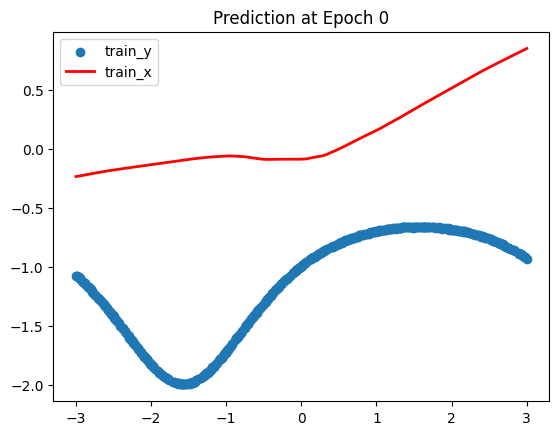

epoch 50 : loss 0.033029879371280005


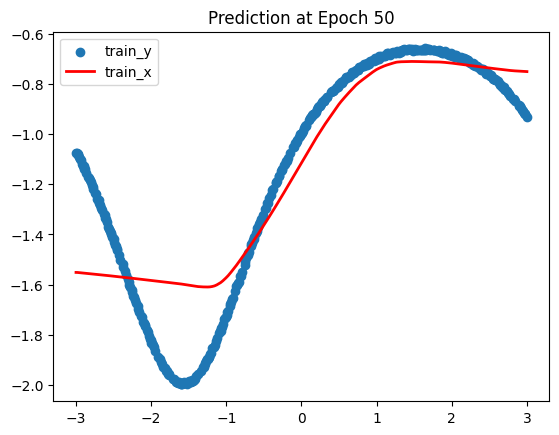

epoch 100 : loss 0.016356988719372932


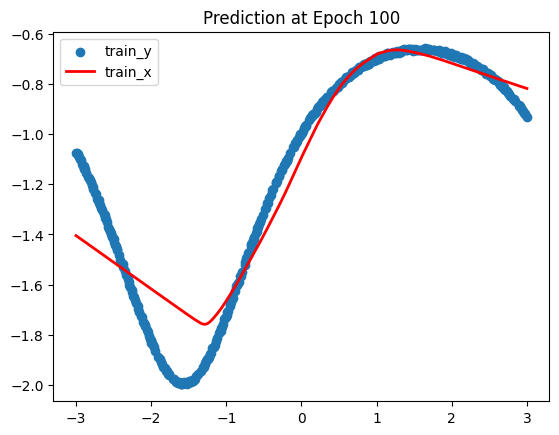

epoch 150 : loss 0.009635504116813647


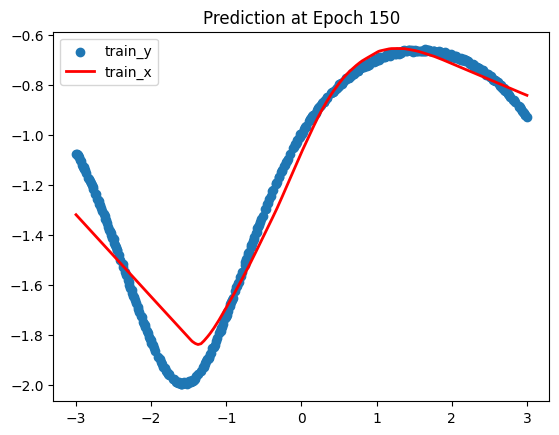

epoch 200 : loss 0.00586801918615153


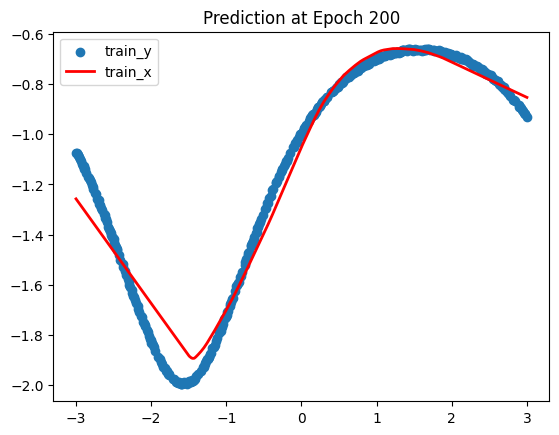

epoch 250 : loss 0.003694943344080861


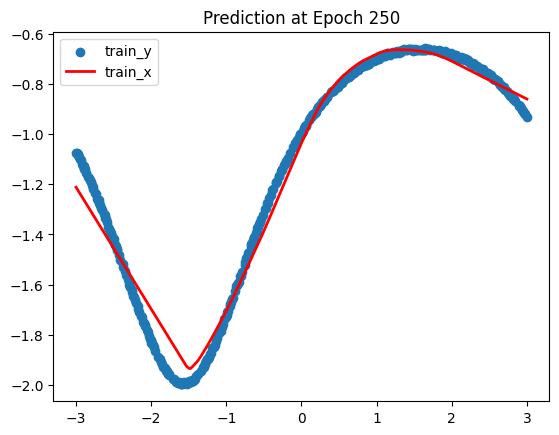

epoch 300 : loss 0.0025666276048856057


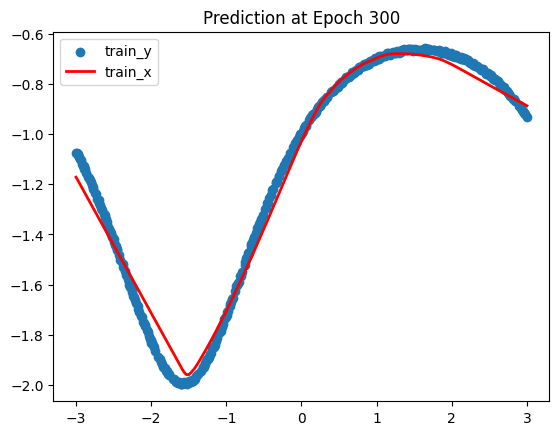

epoch 350 : loss 0.03246531376987775


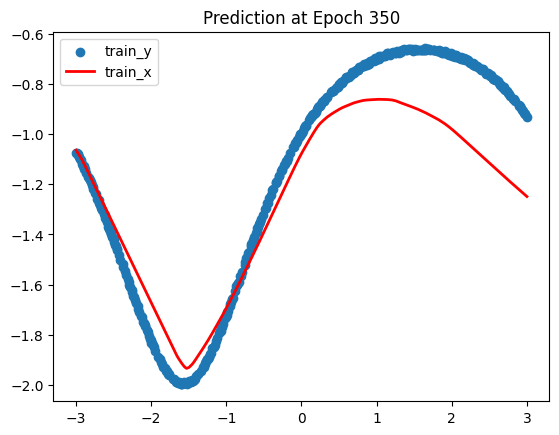

epoch 400 : loss 0.0018066591439258072


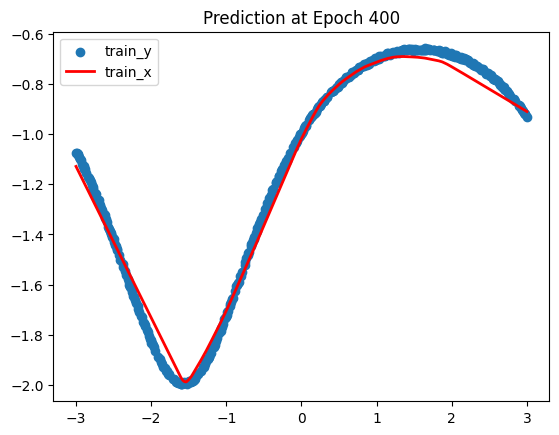

epoch 450 : loss 0.0009821495160332314


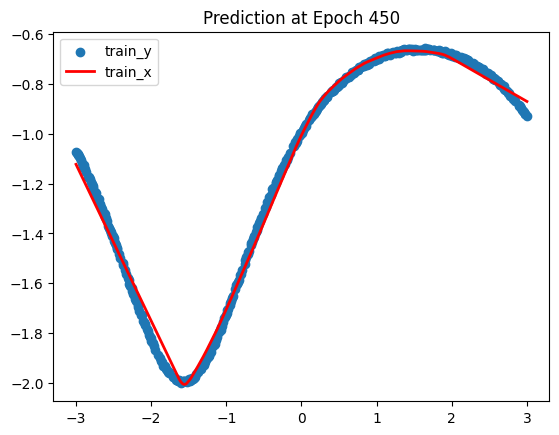

epoch 500 : loss 0.0007444415405090919


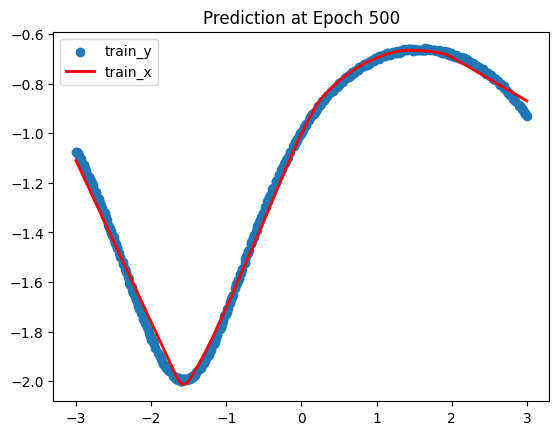

test loss 0.0007728159131833775


In [172]:
import matplotlib.pyplot as plt

(train_x,train_y),(test_x,test_y) = generate_dataset()
for epoch in range(501):
    train_preds,loss = train_one_step(model, train_x , train_y)
    if epoch%50==0:
        print('epoch', epoch, ': loss', loss)
        plt.scatter(train_x, train_y)
        plt.plot(train_x, train_preds, 'r-', lw=2)
        plt.title(f'Prediction at Epoch {epoch}')
        plt.legend(["train_y","train_x"])
        plt.show()

preds, loss= test(model,test_x , test_y)
print('test loss', loss)

## 测试集可视化

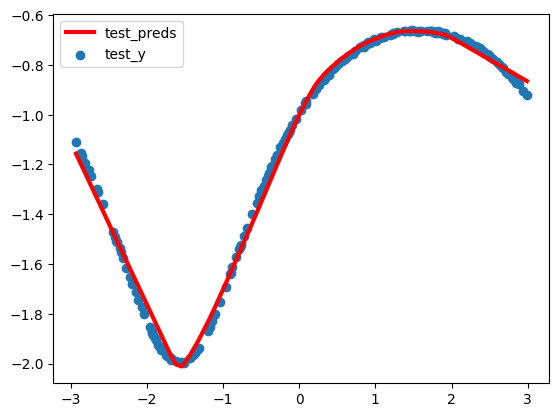

In [173]:
plt.plot(test_x.flatten(),preds.flatten(),color='red',lw=3)
plt.scatter(test_x.flatten(),test_y.flatten())
plt.legend(["test_preds","test_y"])

Text(0.5, 1.0, 'target fun:y=f(x)')

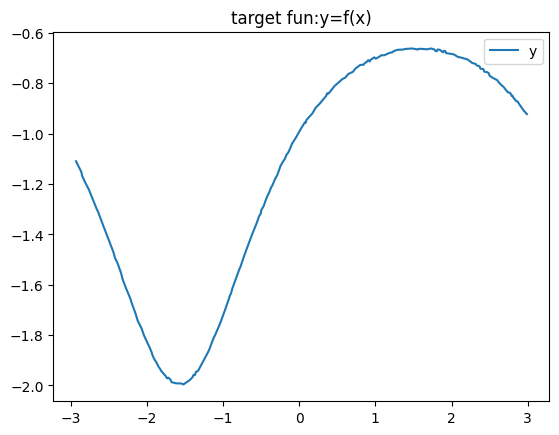

In [179]:
plt.plot(test_x.flatten(),test_y.flatten())
plt.legend("y")
plt.title("target fun:y=f(x)")